### AE4465 (MM&A) - Lecture8 (Data Cleaning)

Data cleaning is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset. There is no one absolute way to prescribe the exact steps in the data cleaning process because the processes will vary from case to case.

In this tutorial we will see how to denoise the FD001 file of CMAPSS data.

In [10]:
#import the necessary libraries
import numpy as np
import pandas as pd
import math
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
df1 = pd.read_csv('data/les05_CMAPSStrain001.txt', sep=' ')
df1.head()

,Equipment,Cycle,Op1,Op2,Op3,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
units = np.unique(df1['Equipment'].values)
df2 = df1.copy()

for unit in units:
    for name_signal in range(21):
        signal = df1.loc[df1.Equipment == unit, str(name_signal + 1)]
        signal_mav = signal.rolling(20).mean().values
        signal_mav[:30] = signal[:30].values
        df2.loc[df2.Equipment == unit, str(name_signal + 1)] = signal_mav

### Comparison with and without denoising

It is possible to compare the results with and without data cleaning.

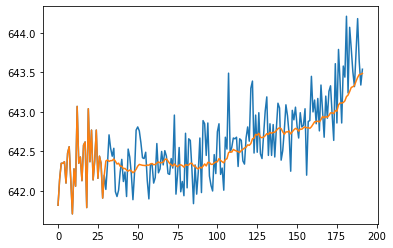

In [12]:
raw_signal = df1.loc[df2.Equipment == 1, str(2)]
noisy_signal = df2.loc[df2.Equipment == 1, str(2)]

plt.plot(raw_signal)
plt.plot(noisy_signal)
plt.show()

In [19]:
def add_rul(g):
    g['RUL'] = max(g['Cycle']) - g['Cycle']
    return g

df1 = df1.groupby('Equipment').apply(add_rul)
df2 = df2.groupby('Equipment').apply(add_rul)

units_test = df1['Equipment'][df1.Equipment.values >= 80]
# data preparation [DF1]

predictions = []
actuals = []

for df in [df1, df2]:
    y1 = df['RUL']/400
    X1 = df.drop(['RUL', 'Equipment'], axis=1)/400

    y_1_train = y1[df.Equipment.values < 80]
    y_1_test = y1[df.Equipment.values >= 80]


    X1_train = X1.loc[df.Equipment < 80, :]
    X1_test = X1.loc[df.Equipment >= 80, :]

    for col in X1_train.columns:
        if np.std(X1_train[col].values) != 0:
            X1_train[col] = (X1_train[col].values - np.mean(X1_train[col].values)) / np.std(X1_train[col].values)
        else:
            X1_train[col] = 1
    for col in X1_train.columns:
        if np.std(X1_test[col].values) != 0:
            X1_test[col] = (X1_test[col].values - np.mean(X1_test[col].values)) / np.std(X1_test[col].values)
        else:
            X1_test[col] = 1

    rfr = RandomForestRegressor(max_depth=3)
    rfr.fit(X1_train, y_1_train)
    predictions.append(rfr.predict(X1_test))
    actuals.append(y_1_test)

    errors = rfr.predict(X1_test) - (y_1_test)
    print('MAE = ', np.mean(np.abs(errors))*400)

c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

MAE =  36.45285148377771


c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

MAE =  36.91694847341179


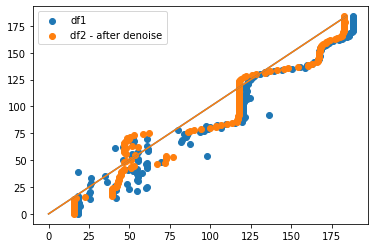

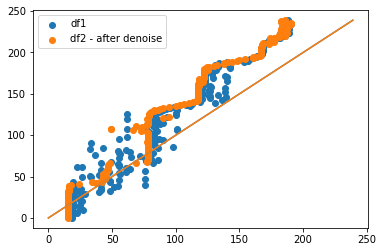

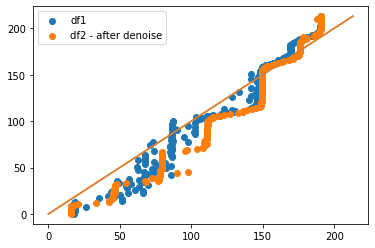

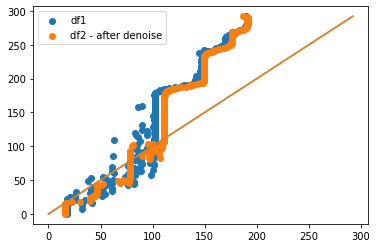

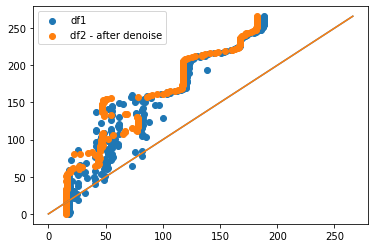

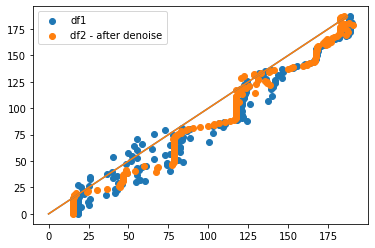

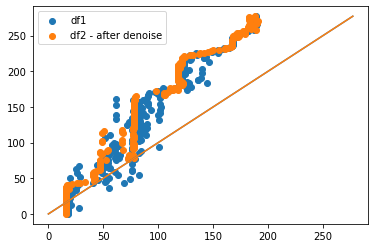

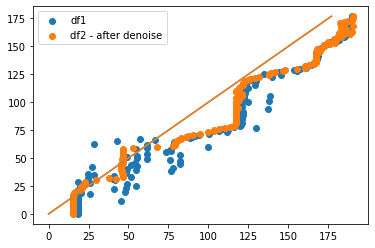

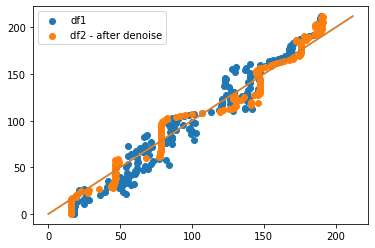

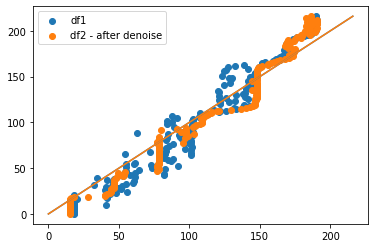

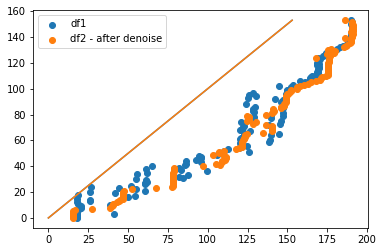

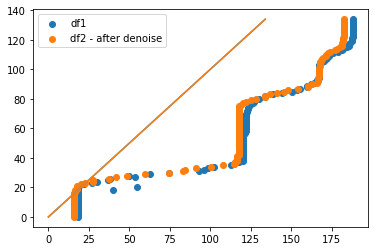

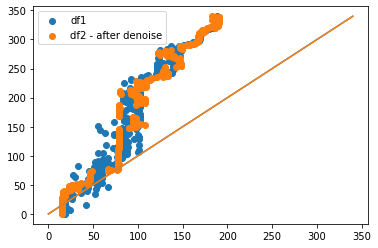

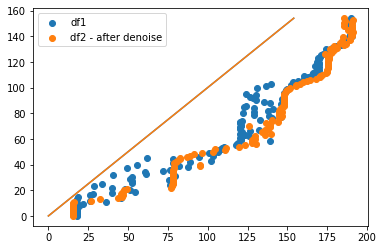

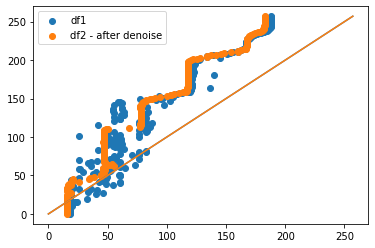

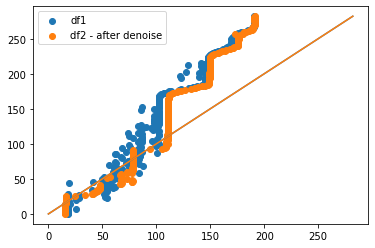

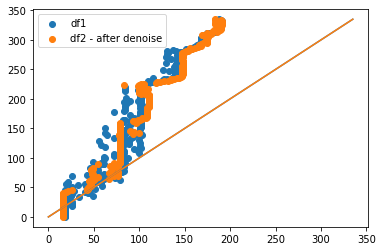

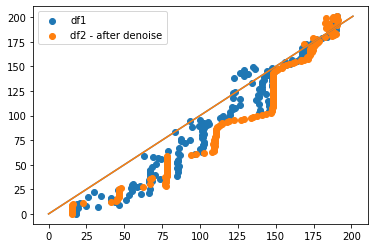

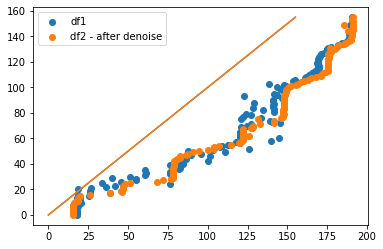

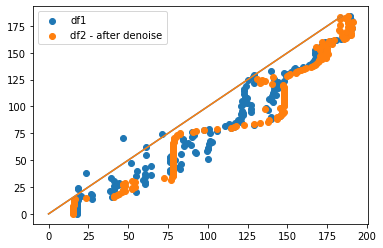

In [25]:
for unit in range(80, 100):
    for prds, acts, label in zip(predictions, actuals, ['df1', 'df2 - after denoise']):
        plt.scatter(prds[units_test.values == unit] * 400, acts[units_test.values == unit] * 400, label=label)
        plt.plot(acts[units_test.values == unit] * 400, acts[units_test.values == unit] * 400)
    plt.legend()
    plt.show()